# Predictors of arsenic content in goundwater
The State of Durango, in northern Mexico, is one of those affected with significant natural presence of arsenic in groundwater (for a national analysis, see [this previous post](https://danielmartinalarcon.github.io/2018-12-14-water-pollution-in-mexico/)).  One of the problems with studying arsenic is that it's expensive to measure it accurately.  But what if we could reliably predict the arsenic content of a water sample, based on other characteristics of the water that are easier to determine?

I used a dataset of water samples from Durango, for which the levels of several common ions had been quantified.  I trained several regression models on these data and found that potassium (K) is by far the factor that is most closely associated with arsenic presence in this dataset.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import category_encoders as ce
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression

pd.set_option('display.max_columns', None)  # Unlimited columns

## Data cleanup

In [2]:
df = pd.read_csv('water_samples.csv', index_col=0)

In [3]:
# Initial state of the dataframe
print(df.shape)
df.head()

(146, 22)


,Municipio,Localidad,Coordenadas,Unnamed: 3,Muestra,FECHA DE MUESTREO,pH,Conductividad (μs/cm),As (μg/L),Flúor (mg/L),Na+ (mg/L),K+ (mg/L),Fe+ (mg/L),Ca+ (mg/L),Mg+ (mg/L),NO3- (mg/L),Cl- (mg/L),CO3-2 (mg/L),HCO3- (mg/L),Alcalinidad total (mg CaCO3/L),SO4,Tipo de Agua
0,NaN,NaN,Longitud,Latitud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Durango,El Nayar,-104.69545,23.96292,60.0,2017-08-08,8.140,337.0,61.5,3.15,40.9220,1.4075,0.007,15.0015,0.2675,3.25,4.140,0.0,97.0,97.0,70.615,BICARBONATADA SODICA
2,Durango,Sebastián Lerdo de Tejada,-104.64026,23.95718,61.0,2017-08-08,8.110,406.0,38.5,2.60,45.8850,0.6100,NaN,20.1530,0.0645,2.10,2.040,0.0,122.0,122.0,79.445,BICARBONATADA SODICA
3,Durango,Felipe Ángeles,-104.55661,23.93505,62.0,2017-08-08,8.375,384.1,26.5,1.40,38.5360,6.3665,NaN,21.8090,1.1890,1.35,2.325,0.0,140.0,140.0,53.730,BICARBONATADA SODICA
4,Durango,Villa Montemorelos,-104.48167,23.99177,63.0,2017-08-08,8.500,557.5,23.5,1.20,31.6805,6.7350,NaN,32.8330,6.5825,4.40,4.680,0.0,206.5,206.5,60.245,BICARBONATADA CALCICA Y/O MAGNESICA


In [63]:
# I rename all columns with simpler English names
df2 = df.rename(
    {'Municipio':'municipality',
     'Localidad':'town',
     'Coordenadas':'longitude',
     'Unnamed: 3':'latitude',
     'Muestra':'id',
     'FECHA DE MUESTREO ':'sampling_date',
     'pH':'pH',
     'Conductividad (μs/cm)':'conductivity',
     'As (μg/L)':'As',
     'Flúor (mg/L)':'F',
     'Na+ (mg/L)':'Na',
     'K+    (mg/L)':'K',
     'Fe+ (mg/L)':'Fe',
     'Ca+ (mg/L)':'Ca',
     'Mg+ (mg/L)':'Mg',
     'NO3- (mg/L)':'nitrate',
     'Cl- (mg/L)':'Cl',
     ' CO3-2 (mg/L)':'carbonate',
     'HCO3- (mg/L)':'bicarbonate',
     'Alcalinidad total                (mg CaCO3/L)':'total_alcalinity',
     'SO4':'sulfate',
     'Tipo de Agua':'water_type'}, axis='columns')

# The first row is garbage, so I remove it and reset the index
df2 = df2.drop(index=0).reset_index(drop=True)

# The id column shouldn't have any predictive power
df2 = df2.drop(columns='id')

# The column for iron (Fe) is the only one with null values, and has 128/146. 
# Probably not worth fixing, so I'll drop it.
df2 = df2.drop(columns='Fe')

# I assume that the sampling date is not important.
df2 = df2.drop(columns='sampling_date')

# I'm only interested in variables that are likely to generalize to 
# other datasets. Though there may be some extra predictive power in the
# locations of these samples, that seems specific to this dataset.
# I will drop geographic variables.

df2 = df2.drop(columns=['longitude','latitude','municipality','town'])

# I'll also reorder the columns a bit
df2 = df2[['As', # Dependent variable first
 'pH',
 'conductivity',
 'F',
 'Na',
 'K',
 'Ca',
 'Mg',
 'nitrate',
 'Cl',
 'carbonate',
 'bicarbonate',
 'total_alcalinity',
 'sulfate',
 'water_type' # Categorical feature last
]]

In [108]:
# Create the datasets for the rest of the notebook
y = df2['As']
X = df2.drop(columns='As')

In [109]:
# One-hot encoding
from sklearn_pandas import DataFrameMapper, cross_val_score

ohe = ce.one_hot.OneHotEncoder(use_cat_names=True)
X = ohe.fit_transform(X)

print(X.shape)
X.head()

(145, 18)


,water_type_BICARBONATADA SODICA,water_type_BICARBONATADA CALCICA Y/O MAGNESICA,water_type_CLORURADAS Y/O SULFATADAS SODICAS,water_type_SULFATADA Y/O CLORURADAS CALCICAS Y/O MAGNESICAS,water_type_-1,pH,conductivity,F,Na,K,Ca,Mg,nitrate,Cl,carbonate,bicarbonate,total_alcalinity,sulfate
0,1,0,0,0,0,8.140,337.0,3.15,40.9220,1.4075,15.0015,0.2675,3.25,4.140,0.0,97.0,97.0,70.615
1,1,0,0,0,0,8.110,406.0,2.60,45.8850,0.6100,20.1530,0.0645,2.10,2.040,0.0,122.0,122.0,79.445
2,1,0,0,0,0,8.375,384.1,1.40,38.5360,6.3665,21.8090,1.1890,1.35,2.325,0.0,140.0,140.0,53.730
3,0,1,0,0,0,8.500,557.5,1.20,31.6805,6.7350,32.8330,6.5825,4.40,4.680,0.0,206.5,206.5,60.245
4,1,0,0,0,0,8.330,326.1,5.95,45.6745,1.6525,8.5190,0.2100,0.52,5.390,0.0,83.0,83.0,59.880


In [110]:
print(y.shape)
y.head()

(145,)


0    61.5
1    38.5
2    26.5
3    23.5
4    97.5
Name: As, dtype: float64

# Model fits

## Linear Regression
Start simple.

In [111]:
lr = LinearRegression()
cv_score = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', 
                cv=10, n_jobs=-1)

print(f'RMSE: {np.sqrt(-np.mean(cv_score)):0.3f}')

RMSE: 43.800


## Ridge Regression
With the optimal k found in a previous notebook

In [112]:
ridge = Ridge(alpha=10)
cv_score = cross_val_score(ridge, X, y, scoring='neg_mean_squared_error', 
                cv=10, n_jobs=-1)

print(f'RMSE: {np.sqrt(-np.mean(cv_score)):0.3f}')

RMSE: 42.682


## Gradient boost regression

In [113]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
cv_score = cross_val_score(gb, X, y, scoring='neg_mean_squared_error', 
                cv=10, n_jobs=-1)

print(f'RMSE: {np.sqrt(-np.mean(cv_score)):0.3f}')

RMSE: 39.098


## Extra trees regression

In [114]:
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(n_estimators=100)
cv_score = cross_val_score(et, X, y, scoring='neg_mean_squared_error', 
                cv=10, n_jobs=-1)

print(f'RMSE: {np.sqrt(-np.mean(cv_score)):0.3f}')

RMSE: 38.956


# Partial Dependence Plots
How much do individual features affect the overal level of arsenic?  The following graphs show the change in predictions caused by several features at different levels of that feature.

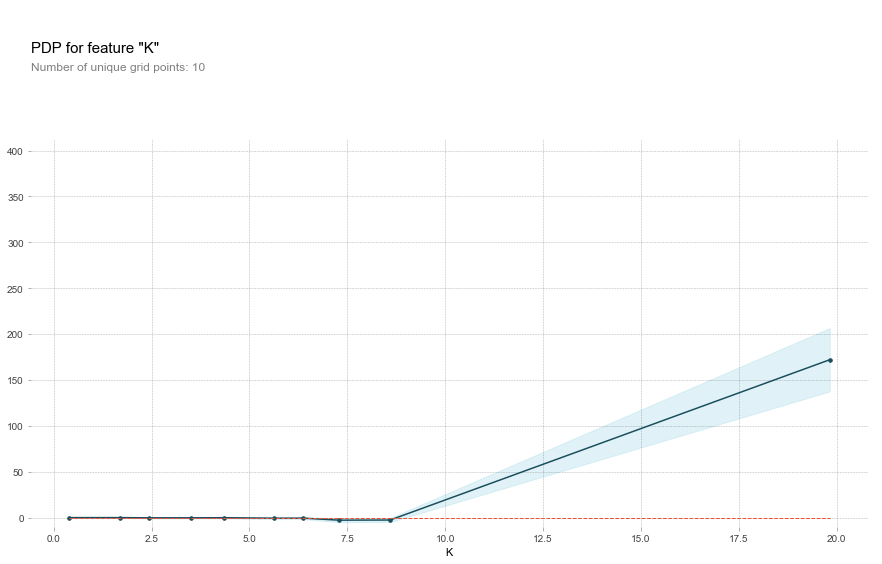

In [117]:
from pdpbox.pdp import pdp_isolate, pdp_plot
gb.fit(X,y)
feature='K'
pdp_isolated = pdp_isolate(model=gb, dataset=X, model_features=X.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

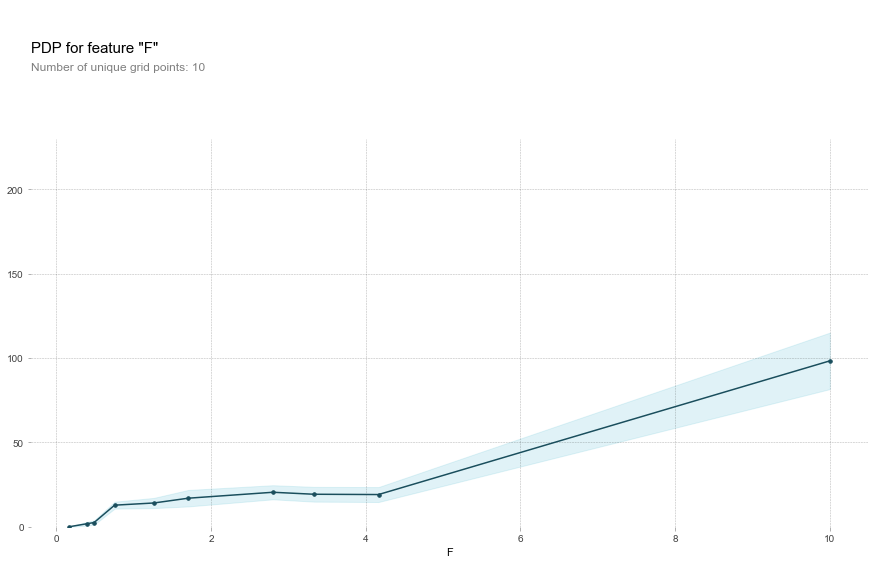

In [118]:
from pdpbox.pdp import pdp_isolate, pdp_plot
gb.fit(X,y)
feature='F'
pdp_isolated = pdp_isolate(model=gb, dataset=X, model_features=X.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

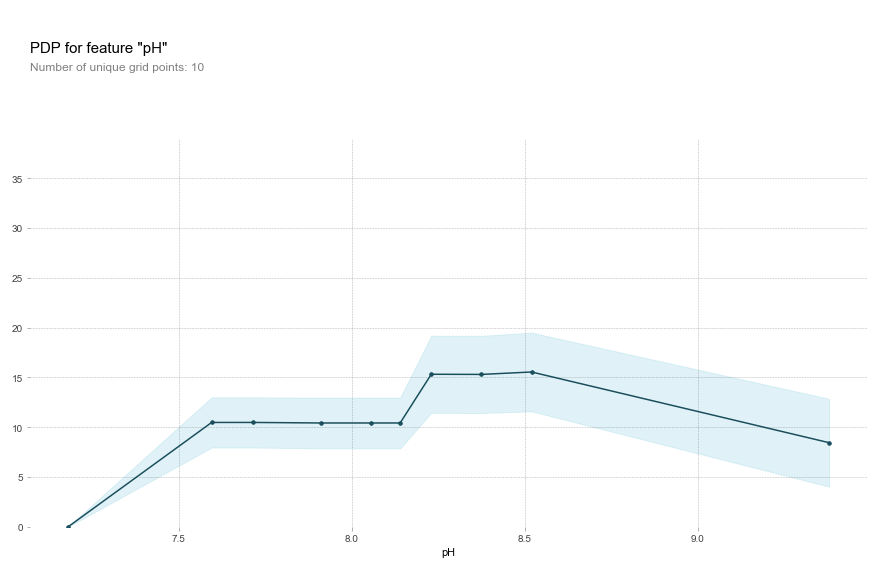

In [115]:
from pdpbox.pdp import pdp_isolate, pdp_plot
gb.fit(X,y)
feature='pH'
pdp_isolated = pdp_isolate(model=gb, dataset=X, model_features=X.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

# Shapley Additive Explanations
It seems clear that K and F drive the model strongly at very high values.  I worry, though, that this might be driven by a few extreme outliers.  Shapley additive explanations will allow us to see individual datapoints and how much different features contribute to the model's predictions.

In [162]:
# Create a dataframe with the predictions from gradient boost and their respective error.
from sklearn.model_selection import cross_val_predict

y_pred_gb = cross_val_predict(gb, X, y, cv=10, n_jobs=-1)

preds = pd.DataFrame({'true': y, 'gb': y_pred_gb, 'gb_error': abs(y - y_pred_gb)})
preds = preds.sort_values(by='gb_error', ascending=False)
preds.head()

,true,gb,gb_error
24,296.5000,29.516953,266.983047
21,286.5000,22.826565,263.673435
5,188.5000,56.657808,131.842192
34,11.2755,96.497569,85.222069
22,100.0000,22.545106,77.454894


First, let's look at the features that contribute to one particular point

In [193]:
data_for_prediction = X.loc[21]
# data_for_prediction

In [194]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(gb)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

Looking at the 20 points with the greatest error, it looks like the Shapley contribution is highest for the points that have potasium values greater than 10.  I'll have to dig deeper to see whether this is an artifact or something useful that we can learn about the data.

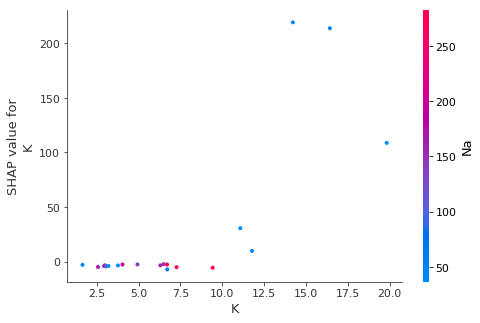

In [204]:
data_for_prediction = X.loc[preds.iloc[:20].index]
shap_values = explainer.shap_values(data_for_prediction)
# shap.summary_plot(shap_values, data_for_prediction)
shap.dependence_plot("K", shap_values, data_for_prediction)

# Feature importances
By Shapley contributions, it seems that potassium and fluoride are by far the most important factors to the model's predictions

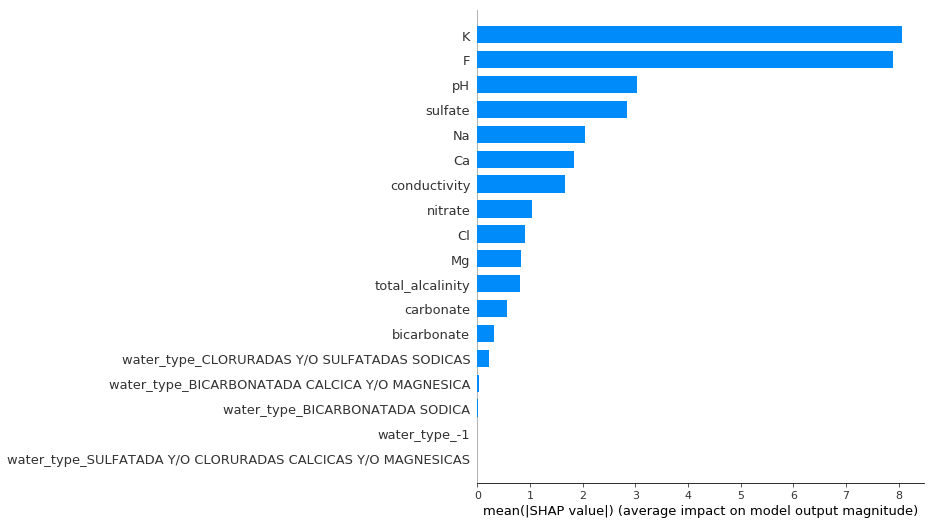

In [141]:
shap.summary_plot(shap_values, X, plot_type="bar")

# Permutation importance
The same pattern shows up for permutation importances.

In [145]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator=gb,
                             scoring='neg_mean_squared_error',
                             n_iter=1,
                             cv='prefit'
                            ).fit(X, y)
eli5.show_weights(perm, 
                  top=None, 
                  feature_names=X.columns.tolist())

Weight,Feature
1494.4827 ± 0.0000,K
446.0002 ± 0.0000,F
69.3812 ± 0.0000,sulfate
50.4514 ± 0.0000,Ca
50.0288 ± 0.0000,pH
37.3397 ± 0.0000,Na
33.9464 ± 0.0000,conductivity
26.5433 ± 0.0000,nitrate
18.3851 ± 0.0000,total_alcalinity
12.9024 ± 0.0000,Cl


In fact, we can use these feature importances to get rid of the features that don't contribute at least 5% to the explanatory power of the overall model.

In [152]:

from sklearn.feature_selection import SelectFromModel
# perm.feature_importances_ attribute is now available, it can be used
# for feature selection - let's e.g. select features which increase
# accuracy by at least 0.05:
sel = SelectFromModel(perm, threshold=0.05, prefit=True)
dumped_features = X.columns[~sel.get_support()]

In [153]:
dumped_features

Index(['water_type_BICARBONATADA SODICA',
       'water_type_BICARBONATADA CALCICA Y/O MAGNESICA',
       'water_type_SULFATADA Y/O CLORURADAS CALCICAS Y/O MAGNESICAS',
       'water_type_-1'],
      dtype='object')